In [2]:
#import library for image segmentation

from PIL import Image   
import numpy as np 
from scipy import ndimage #library for distance transformation
from skimage.feature import peak_local_max # library for 
from skimage.morphology import watershed # library for morphology detection
import cv2  #Open CV library
from matplotlib import pyplot as plt

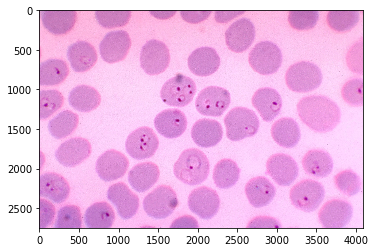

In [12]:
#import .jpg image
image = cv2.imread("test1.jpg")

plt.imshow(image)

In [6]:
# image preprocessing - identify cell boundary

# convert image into grayscale and thresholding
img = cv2.medianBlur(image, 3)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
darker = cv2.equalizeHist(gray)
ret,thresh = cv2.threshold(darker,0,255,cv2.THRESH_OTSU)
image_gray = cv2.bitwise_not(thresh)

#identify kernel for manipulating image
kernel = np.ones((11,11),np.uint8)
kernel1 = np.ones((3,3),np.uint8)

# fill to identify the boundary of cell
image_edged = cv2.dilate(image_gray, kernel1, iterations=3)
image_edged = cv2.erode(image_edged, kernel1, iterations=1)
closing = cv2.morphologyEx(image_edged, cv2.MORPH_CLOSE, kernel)
   
#watershed segmentation
D = ndimage.distance_transform_edt(closing)
localMax = peak_local_max(D, indices=False, min_distance=200, labels=closing)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=closing)

print("[INFO] {} unique segments of cell boundary found".format(len(np.unique(labels)) - 1))

[INFO] 35 unique segments found


In [7]:
# image preprocessing - identify infected region

#  grayscale image thresholding
(thresh, im_bw) = cv2.threshold(gray, 150, 255,  cv2.THRESH_BINARY_INV)

#watershed segmentation
D2 = ndimage.distance_transform_edt(im_bw)
localMax = peak_local_max(D2, indices=False, min_distance=50, labels=im_bw)
markers1 = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels1 = watershed(-D2, markers1, mask=im_bw)

print("[INFO] {} unique segments of infected region found".format(len(np.unique(labels1)) - 1))

[INFO] 230 unique segments of infected region found


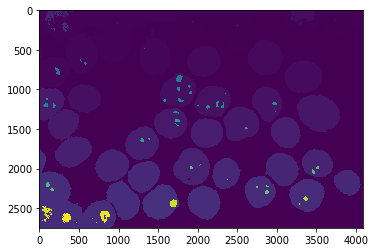

In [9]:
#overlay watershed segmentation region of cell boundary and infected region
comb = labels|labels1

plt.imshow(comb)

In [10]:
# get position of watershed segmentation - cell boundary
import imutils

x_pos = []
y_pos = []
radius = []

#get only one values of position and radius from cell labeling
for label in np.unique(labels):
    if label == 0:
        continue
     
    #mask watershed label into int values
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
 
    # detect contours in the mask and grab the largest
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
 
    # get position from the largest object and store in variables
    ((x, y), r) = cv2.minEnclosingCircle(c)
    x_pos.append(x)
    y_pos.append(y)
    radius.append(r)

In [11]:
# get position of watershed segmentation - infected region

x_pos_in = []
y_pos_in = []
radius_in = []

#get only one values of position and radius from infected object
for label in np.unique(labels1):
    if label == 0:
        continue
 
    #mask watershed label into int values
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels1 == label] = 255
 
    # detect contours in the mask and grab the largest 
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
 
    # get position from the largest object and store in variables
    ((x, y), r) = cv2.minEnclosingCircle(c)
    x_pos_in.append(x)
    y_pos_in.append(y)
    radius_in.append(r)